### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import drive, files

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# point to the drive directory
endo_dir = '/content/drive/MyDrive/endometriosis/'

In [4]:
# predictions_file = os.path.join(endo_dir, 'output', 'predictions', 'old', 'persona_predictions.csv')
# predictions = pd.read_csv(predictions_file)

In [5]:
personas_file = os.path.join(endo_dir, 'output', 'predictions', 'PERSONAS', 'personas_predictions.pkl')
personas = pd.read_pickle(personas_file)
len(personas)

589814

In [6]:
topic_distributions_file = os.path.join(endo_dir, 'output', 'topic-modeling', 'parags', 'endo+endometriosis-25_10.pkl')
distributions = pd.read_pickle(topic_distributions_file).reset_index().rename(columns = {"index":"id"})
len(distributions)

527083

### Transform topic distributions to z-scores and add to the personas predictions

In [7]:
# big_df = pd.merge(distributions, predictions[['id',
#                                         'predictions_DOCTORS',
#                                         'predictions_FAMILY',
#                                         'predictions_ENDO-SUPPORT-COMMUNITY',
#                                         'predictions_PARTNER']],
#                   how = "left", left_on = "id", right_on = "id")
# print(len(big_df))
# big_df.dropna(inplace=True)
# print(len(big_df))
# big_df.columns

In [8]:
# cols = list(big_df.columns[1:26])
# # get z scores for each topic column
# for col in cols:
#   big_df[col] = (big_df[col] - big_df[col].mean()) / big_df[col].std()

In [9]:
zscores = distributions.copy()
cols = list(zscores.columns[1:26])
# get z scores for each topic column
for col in cols:
  zscores[col] = stats.zscore(zscores[col])

In [10]:
big_df = pd.merge(zscores, personas[['id',
                                        'predictions_DOCTORS',
                                        'predictions_FAMILY',
                                        'predictions_ENDO SUPPORT COMMUNITY',
                                        'predictions_PARTNER']],
                  how = "left", left_on = "id", right_on = "id")
print('Length df after merge:', len(big_df))

Length df after merge: 527116


In [11]:
dupes = big_df[['id', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5',
       'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11',
       'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16', 'Topic 17',
       'Topic 18', 'Topic 19', 'Topic 20', 'Topic 21', 'Topic 22', 'Topic 23',
       'Topic 24', 'predictions_DOCTORS',
       'predictions_FAMILY', 'predictions_ENDO SUPPORT COMMUNITY',
       'predictions_PARTNER']].duplicated()
dupes_idx = dupes.loc[dupes == True].index
print('Number of dupes', len(dupes_idx))
big_df.drop(dupes_idx, inplace=True)
print('Length df after removing dupes', len(big_df))

Number of dupes 33
Length df after removing dupes 527083


In [12]:
assert(len(distributions) == len(big_df))

In [13]:
big_df['type'] = big_df['id'].apply(lambda x: str(x).split('_')[2])

In [14]:
big_df = big_df.loc[big_df['type'] == 'post']
len(big_df)

90652

### Create new df with topic zscores as rows and personas as columns

In [15]:
# #predictions_DOCTORS
# cond = (big_df['predictions_DOCTORS'] == 1) & (big_df['predictions_FAMILY'] == 0) & (['predictions_ENDO SUPPORT COMMUNITY'] == 0) #& (big_df['predictions_PARTNER'] == 0)
# persona_df = big_df[cond]
# persona_col = pd.DataFrame(persona_df[persona_df.columns[1:26]].mean()).rename(columns = {0:'Doctors'})
# new_columns.append(persona_col)
# persona_col.head()

In [16]:
new_columns = []
personas = ['Doctors', 'Endo support community', 'Partner', 'Family']
for persona in personas:
  predictions_column_name = f'predictions_{persona.upper()}'
  persona_df = big_df[big_df[predictions_column_name] == 1]
  persona_col = pd.DataFrame(persona_df[persona_df.columns[1:26]].mean()).rename(columns = {0:persona})
  new_columns.append(persona_col)
personas_zscores = pd.concat(new_columns, axis = 1)
personas_zscores.iloc[:2]

,Doctors,Endo support community,Partner,Family
Topic 0,-0.115432,-0.091311,-0.155201,-0.150197
Topic 1,0.021548,-0.043347,-0.118653,-0.157761


### Reorder and change index to topics full names

In [17]:
reordered_topic_names = ["Topic 0: Gastrointestinal",
    "Topic 3: Pelvic floor",
    "Topic 5: Menstruation",
    "Topic 17: Muscular ",
    "Topic 21: Sharing symptoms",
    "Topic 14: Pain management",
    "Topic 23: Drugs",
    "Topic 18: Hormonal drug experiences",
    "Topic 24: Info on hormonal drugs",
    "Topic 1: Information on surgery",
    "Topic 2: Medical information",
    "Topic 4: Getting diagnosed",
    "Topic 6: Online resources",
    "Topic 9: Specialists",
    "Topic 13: Insurance",
    "Topic 20: Medical appointments",
    "Topic 8: Post surgery recovery",
    "Topic 15: Product recommendations",
    "Topic 19: Diet",
    "Topic 22: Comfort items",
    "Topic 7: Dismissal",
    "Topic 10: Gratitude",
    "Topic 11: Medical stories",
    "Topic 12: Fertility",
    "Topic 16: Empathy",
    ]

In [18]:
reordered_topics_nums = [topic_name.split(":")[0] for topic_name in reordered_topic_names]
reordered_df = personas_zscores.reindex(reordered_topics_nums)
reordered_df[:2]

,Doctors,Endo support community,Partner,Family
Topic 0,-0.115432,-0.091311,-0.155201,-0.150197
Topic 3,-0.071177,-0.078166,-0.053134,-0.135684


In [19]:
reordered_df['topics_names'] = reordered_topic_names
reordered_df.set_index('topics_names', inplace=True)
reordered_df[:2]

,Doctors,Endo support community,Partner,Family
topics_names,,,,
Topic 0: Gastrointestinal,-0.115432,-0.091311,-0.155201,-0.150197
Topic 3: Pelvic floor,-0.071177,-0.078166,-0.053134,-0.135684


In [20]:
sns.set(font_scale=1.8)

#cmap = sns.diverging_palette(145, 300, s=90, as_cmap=True) # purple high, green low
cmap = sns.diverging_palette(300, 145, s=90, as_cmap=True) # green high, purple low

### Create big image

In [21]:
reordered_df = reordered_df.rename(columns = {"Doctors": "Medical Professional", "Endo support community":"Endometriosis OHCs"})

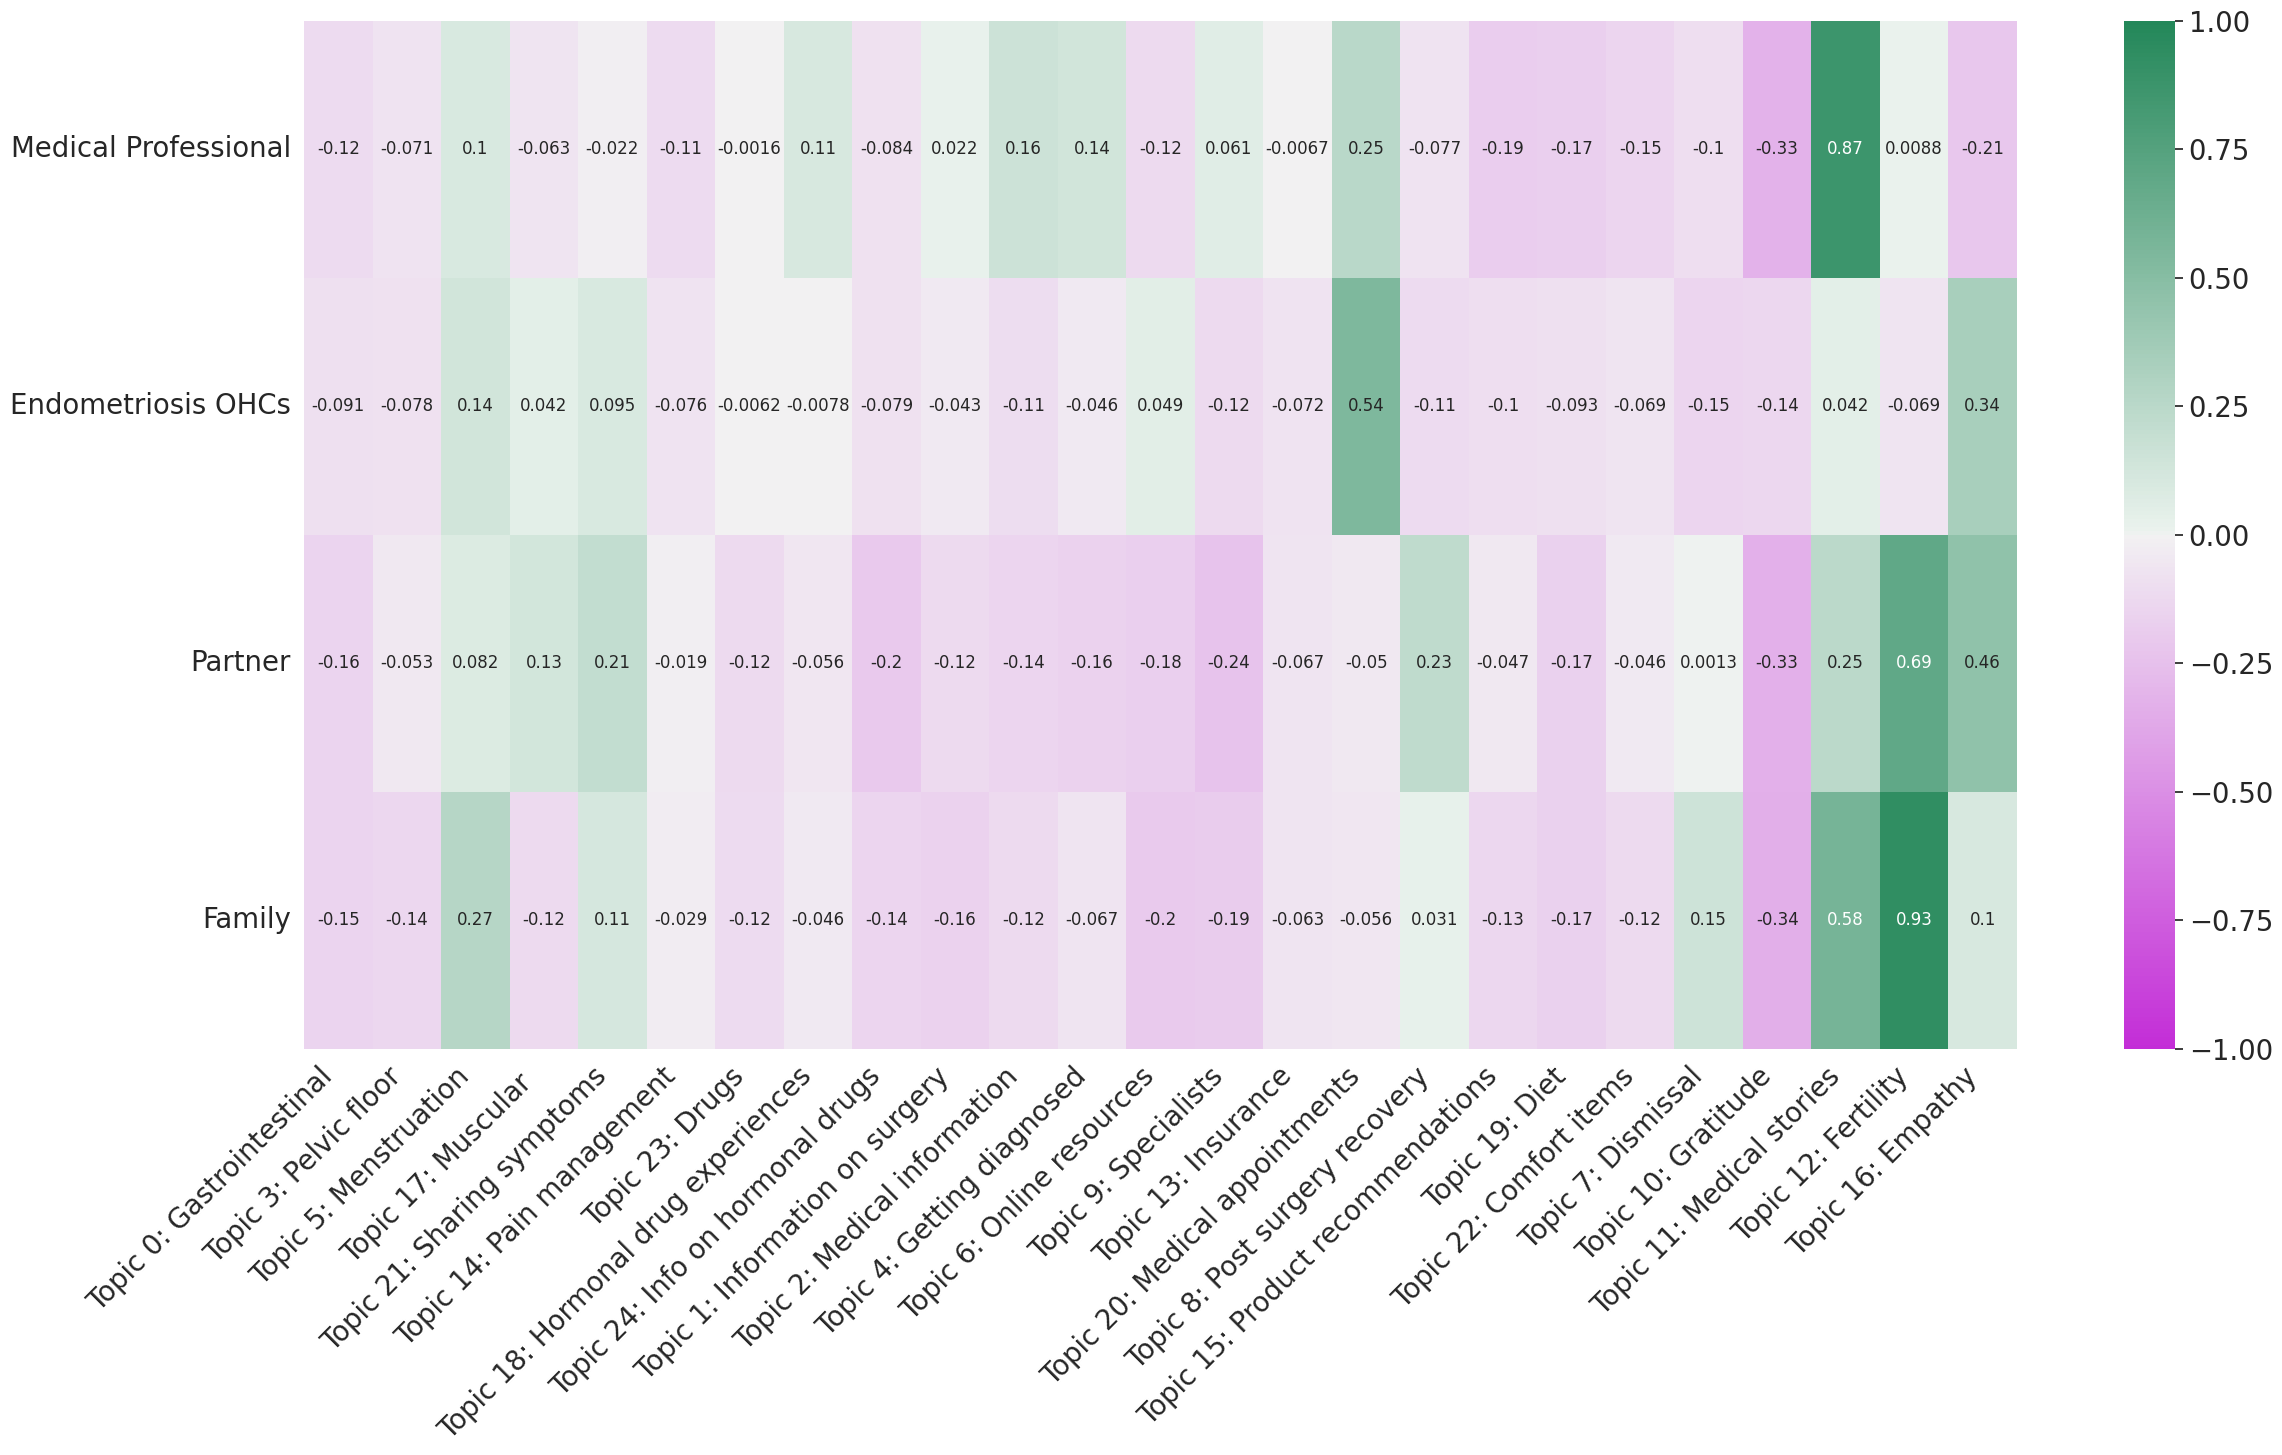

In [22]:
plt.figure(figsize=(25, 15))
heatmap = sns.heatmap(reordered_df.T, vmin=-1, vmax=1, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.ylabel('', fontsize = 30)
plt.xlabel('', fontsize = 30)
plt.tight_layout()


plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Personas_Topics', 'posts.png'), dpi = 300,  bbox_inches = "tight")

### Code for permutation test

In [23]:
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def other_permutation_test(ddf, persona, topic):

  column = f'predictions_{persona.upper()}'
  x = ddf.loc[ddf[column] == 0][topic]
  y = ddf.loc[ddf[column] == 1][topic]
  res = stats.permutation_test((x, y), statistic, vectorized=True, n_resamples=1000)

  return res.pvalue

In [24]:
def permute(input_array):
  # shuffle is inplace, so copy to preserve input
  permuted = input_array.copy().values  # convert to numpy array, avoiding warning
  np.random.shuffle(permuted)
  return permuted  # convert back to pandas

def permutation_test(ddf, persona, topic):
  column = f'predictions_{persona.upper()}'
  # Difference between the mean of the values in the first half and the mean of the values in the second half of the corpus
  real_mean_0 = ddf.loc[ddf[column] == 0][topic].mean()
  real_mean_1 = ddf.loc[ddf[column] == 1][topic].mean()
  diff_real = real_mean_0 - real_mean_1

  # Performing 1,000 permutations
  n_permutations = 1000
  flag = 0
  for i in range(n_permutations):
      copy = ddf.copy()  # we copy the original dataframe with the observed data
      copy[column] = permute(copy[column])  # we shuffle the 'year' column
      mean_before = copy.loc[copy[column] == 0][topic].mean()
      mean_after = copy.loc[copy[column] == 1][topic].mean()
      diff_perm = mean_before - mean_after  # we calculate the difference between the means of the two halves of the corpus
      if diff_real > 0:  # if real difference is a positive number
          if diff_real > diff_perm:  # we test if the observed difference is greater
              flag += 1
      if diff_real < 0:  # if real difference is a negative number
          if diff_real < diff_perm:  # we test if the observed difference is lesser
              flag += 1  # we keep count of the number of times the observed difference is larger
  p = (n_permutations-flag)/n_permutations

  return diff_real, flag, p

In [29]:
personas = ['Doctors']#, 'Endo support community', 'Partner', 'Family']
for _topic in ['Topic 16', 'Topic 7']: #reordered_topics_nums:
  for _persona in personas:
    print(f'{_topic}___{_persona} vs non-{_persona}')
    # diff, flag_value, p_value = permutation_test(big_df, _persona, _topic)
    # print('\nMy Test')
    # print(f'Observed difference: {diff}')
    # print(f'Number of times observed difference is larger than permutated: {flag_value}')
    # print(f'P-value: {p_value}')
    p_value = other_permutation_test(big_df, _persona, _topic)
    print('\nScipy Test')
    print(f'P-value: {p_value}')

Topic 16___Doctors vs non-Doctors

Scipy Test
P-value: 0.001998001998001998
Topic 7___Doctors vs non-Doctors

Scipy Test
P-value: 0.7612387612387612


In [26]:
personas = ['Endo support community'] # 'Partner', 'Family']
for _topic in ['Topic 20']: #reordered_topics_nums:
  for _persona in personas:
    print(f'{_topic}___{_persona} vs non-{_persona}')
    # diff, flag_value, p_value = permutation_test(big_df, _persona, _topic)
    # print('\nMy Test')
    # print(f'Observed difference: {diff}')
    # print(f'Number of times observed difference is larger than permutated: {flag_value}')
    # print(f'P-value: {p_value}')
    p_value = other_permutation_test(big_df, _persona, _topic)
    print('\nScipy Test')
    print(f'P-value: {p_value}')

Topic 20___Endo support community vs non-Endo support community

Scipy Test
P-value: 0.001998001998001998


In [31]:
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)


x = big_df.loc[big_df['predictions_DOCTORS'] == 1]['Topic 20']
y = big_df.loc[big_df['predictions_ENDO SUPPORT COMMUNITY'] == 1]['Topic 20']
res = stats.permutation_test((x, y), statistic, vectorized=True, n_resamples=1000)
res.pvalue

0.001998001998001998

In [27]:
personas = ['Partner', 'Family']
for _topic in ['Topic 12']: #reordered_topics_nums:
  for _persona in personas:
    print(f'{_topic}___{_persona} vs non-{_persona}')
    # diff, flag_value, p_value = permutation_test(big_df, _persona, _topic)
    # print('\nMy Test')
    # print(f'Observed difference: {diff}')
    # print(f'Number of times observed difference is larger than permutated: {flag_value}')
    # print(f'P-value: {p_value}')
    p_value = other_permutation_test(big_df, _persona, _topic)
    print('\nScipy Test')
    print(f'P-value: {p_value}')

Topic 12___Partner vs non-Partner

Scipy Test
P-value: 0.001998001998001998
Topic 12___Family vs non-Family

Scipy Test
P-value: 0.001998001998001998


In [28]:
personas = ['Partner']
for _topic in ['Topic 8']: #reordered_topics_nums:
  for _persona in personas:
    print(f'{_topic}___{_persona} vs non-{_persona}')
    # diff, flag_value, p_value = permutation_test(big_df, _persona, _topic)
    # print('\nMy Test')
    # print(f'Observed difference: {diff}')
    # print(f'Number of times observed difference is larger than permutated: {flag_value}')
    # print(f'P-value: {p_value}')
    p_value = other_permutation_test(big_df, _persona, _topic)
    print('\nScipy Test')
    print(f'P-value: {p_value}')

Topic 8___Partner vs non-Partner

Scipy Test
P-value: 0.001998001998001998


### Symptoms

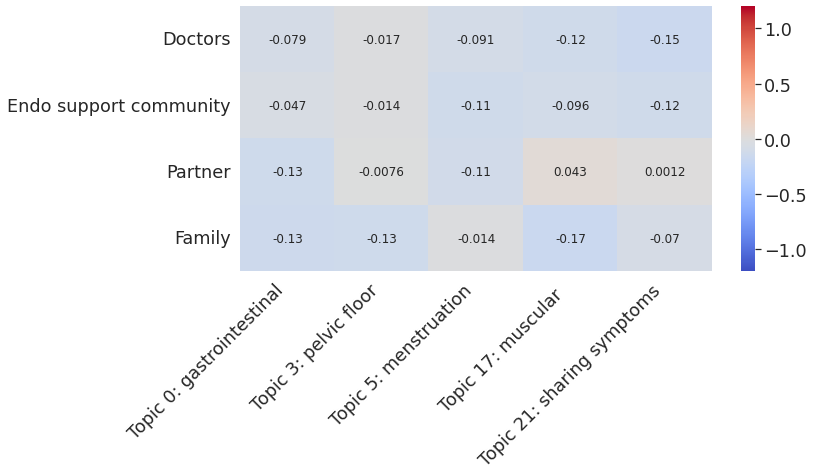

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[0:5].T, vmin=-1.20, vmax=1.20, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Personas_Topics', 'personas_symptoms.png'), dpi = 300)

In [ ]:
# Less talk of pelvic floor with family
diff, flag_value, p_value = permutation_test(big_df, 'Family', 'Topic 3')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.13732727151364088
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk of menstruation with family
diff, flag_value, p_value = permutation_test(big_df, 'Family', 'Topic 5')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.014291923842392862
Number of times observed difference is larger than permutated: 990
P-value: 0.01



In [ ]:
# More talk of muscular pain with partner
diff, flag_value, p_value = permutation_test(big_df, 'Partner', 'Topic 17')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.04491679510101676
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less talk of muscular pain with family
diff, flag_value, p_value = permutation_test(big_df, 'Family', 'Topic 17')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.17581537459045649
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More sharing symptoms with partner
diff, flag_value, p_value = permutation_test(big_df, 'Partner', 'Topic 21')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.0012212306792207528
Number of times observed difference is larger than permutated: 535
P-value: 0.465



In [ ]:
# Less sharing symptoms with doctor
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 21')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.2244281992316246
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



### Medications

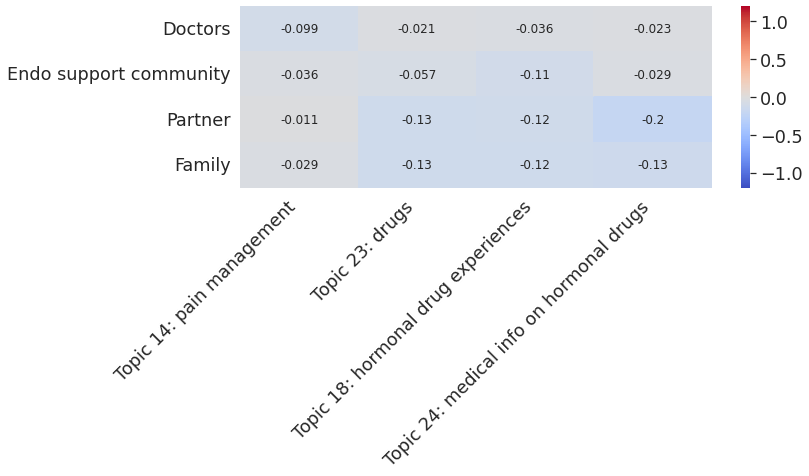

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[5:9].T, vmin=-1.20, vmax=1.20, center=0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Personas_Topics', 'personas_medications.png'), dpi = 300)

In [ ]:
# Less pain management (14) with doctor
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 14')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.146466676145792
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More horm drug experiences (18) with doctor
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 18')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.05388142727315426
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less medical info on horm drugs (24) with partner
diff, flag_value, p_value = permutation_test(big_df, 'Partner', 'Topic 24')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.20635057240724564
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More medical info on horm drugs (24) with doctors
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 24')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.03450743667781353
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More medical info on horm drugs (24) with endo community
diff, flag_value, p_value = permutation_test(big_df, 'Endo support community', 'Topic 24')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.04997821897268295
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



### Healthcare

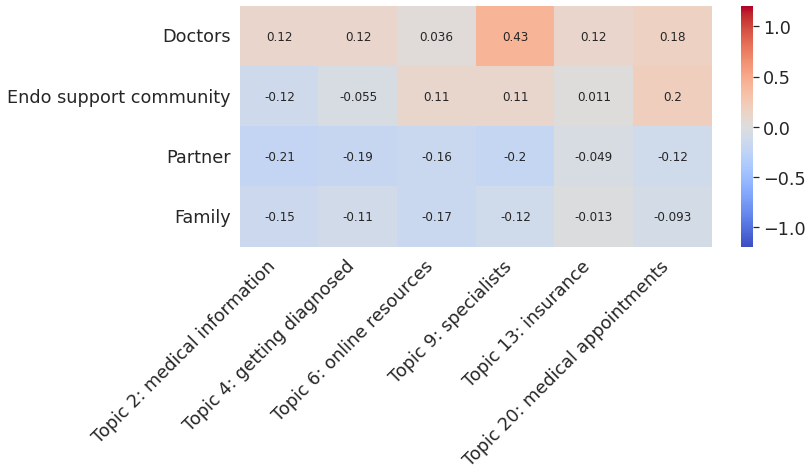

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[9:15].T, vmin=-1.20, vmax=1.20, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Personas_Topics', 'personas_healthcare.png'), dpi = 300)

In [ ]:
# More specialists (9) with doctors
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 9')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.6371191740036011
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More medical appointments (20) with doctors
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 20')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.26159293949604034
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More medical appointments (20) with endo support community
diff, flag_value, pvalue = permutation_test(big_df, 'Endo support community', 'Topic 20')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.3490413874387741
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Low specialists (9) with partner
diff, flag_value, p_value = permutation_test(big_df, 'Partner', 'Topic 9')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.21086223050951958
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



### Self care

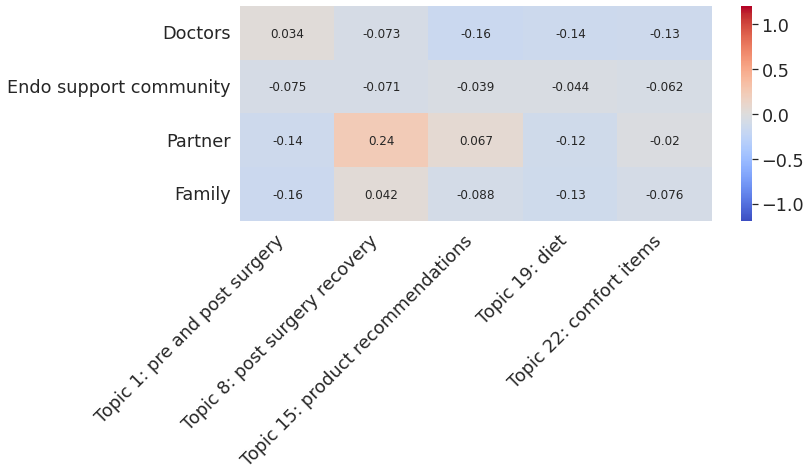

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[15:20].T, vmin=-1.20, vmax=1.20, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Personas_Topics', 'personas_selfcare.png'), dpi = 300)

In [ ]:
# More talk about pre and post (1) with doctors
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 1')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.05041913501918316
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less talk about post (8) with doctor
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 8')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.10817224904894829
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about post (8) with partner
diff, flag_value, p_value = permutation_test(big_df, 'Partner', 'Topic 8')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.2472383426502347
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about post (8) with family
diff, flag_value, p_value = permutation_test(big_df, 'Family', 'Topic 8')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.04461697884835303
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less talk about product recommendations (15) with doctors
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 15')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.24426444619894028
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about product recommendations (15) with partner
diff, flag_value, p_value = permutation_test(big_df, 'partner', 'Topic 15')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.0694035105407238
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Less talk about diet (19) with doctors
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 19')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.21400564908981323
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



### Life issues

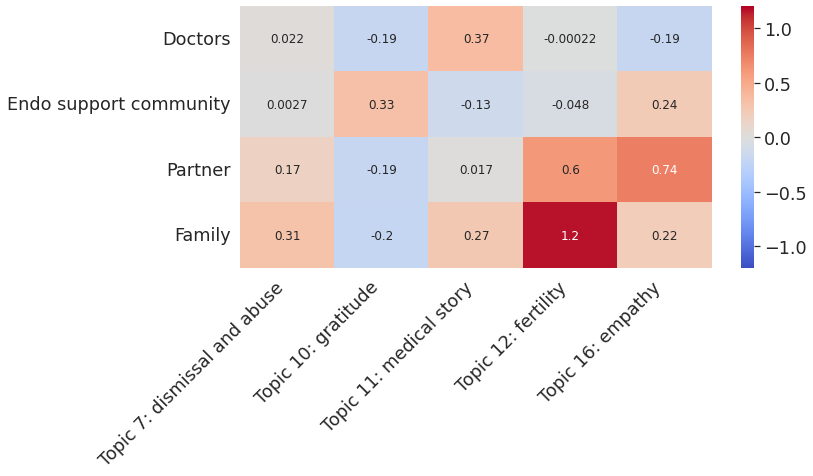

In [ ]:
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(reordered_df.iloc[20:25].T, vmin=-1.20, vmax=1.20, center = 0, annot=True, annot_kws={"size": 12}, cmap=cmap)
plt.yticks(rotation=360, ha='right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(endo_dir, 'output', 'figures', 'Personas_Topics', 'personas_lifeissues.png'), dpi = 300)

In [ ]:
# More talk about dismissal and abuse (7) with family
diff, flag_value, p_value = permutation_test(big_df, 'Family', 'Topic 7')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.3256515897810459
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about gratitude (10) with Endo support community
diff, flag_value, p_value = permutation_test(big_df, 'Endo support community', 'Topic 10')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.5814726501703262
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about fertility (12) with Family
diff, flag_value, p_value = permutation_test(big_df, 'Family', 'Topic 12')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -1.2277661748230457
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about fertility (12) with Partner
diff, flag_value, p_value = permutation_test(big_df, 'Partner', 'Topic 12')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.6267265267670155
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# More talk about empathy (16) with Partner
diff, flag_value, p_value = permutation_test(big_df, 'Partner', 'Topic 16')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: -0.7734042424708605
Number of times observed difference is larger than permutated: 1000
P-value: 0.0



In [ ]:
# Low talk about empathy (16) with Doctors
diff, flag_value, p_value = permutation_test(big_df, 'Doctors', 'Topic 16')
print(f'Observed difference: {diff}')
print(f'Number of times observed difference is larger than permutated: {flag_value}')
print(f'P-value: {p_value}\n')

Observed difference: 0.28653358668088913
Number of times observed difference is larger than permutated: 1000
P-value: 0.0

